In [6]:
!pip install seaborn
!pip install imblearn
!pip install pandas numpy seaborn matplotlib scikit-learn imbalanced-learn joblib




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [10]:
# Load dataset
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

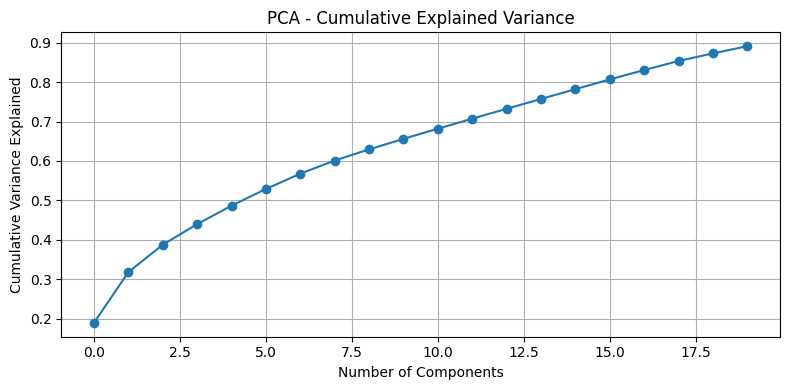

In [11]:

df_train = pd.read_csv("kddtrain+.txt", names=columns)
df_test = pd.read_csv("kddtest+.txt", names=columns)
df_train.drop(['difficulty'], axis=1, inplace=True)
df_test.drop(['difficulty'], axis=1, inplace=True)
df = pd.concat([df_train, df_test])

# Binary classification
df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomaly')

# Encode categorical features
for col in ['protocol_type', 'service', 'flag']:
    df[col] = LabelEncoder().fit_transform(df[col])

df.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Features and labels
X = df.drop('label', axis=1)
y = df['label']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

# PCA Variance Plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("PCA - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

# SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_pca, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [12]:

# Define individual models
knn = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=-1)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train individual models
for name, model in [("KNN", knn), ("Decision Tree", dt), ("Random Forest", rf)]:
    print(f"\n🚀 Training {name}")
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start
    print(f"⏱️ Time: {duration:.2f}s")

# Voting Classifier (Hard Voting)
voting = VotingClassifier(
    estimators=[('knn', knn), ('dt', dt), ('rf', rf)],
    voting='hard', n_jobs=-1
)
voting.fit(X_train, y_train)

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[('knn', knn), ('dt', dt), ('rf', rf)],
    final_estimator=LogisticRegression(), n_jobs=-1
)
stacking.fit(X_train, y_train)

# Evaluation Function
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label='anomaly')
    rec = recall_score(y_test, y_pred, pos_label='anomaly')
    f1 = f1_score(y_test, y_pred, pos_label='anomaly')

    print(f"\n📌 Evaluation: {name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall: {rec:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")



🚀 Training KNN
⏱️ Time: 1.11s

🚀 Training Decision Tree
⏱️ Time: 9.53s

🚀 Training Random Forest
⏱️ Time: 30.84s


In [19]:
# Function to evaluate the model and track time
def evaluate_model(name, model):
    print(f"\n🚀 Evaluating: {name}")
    
    # Track the time for training and prediction
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_time
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=["normal", "anomaly"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["normal", "anomaly"],
                yticklabels=["normal", "anomaly"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("📊 Classification Report:\n", classification_report(y_test, y_pred))
    
    return train_time, pred_time


🚀 Evaluating: KNN


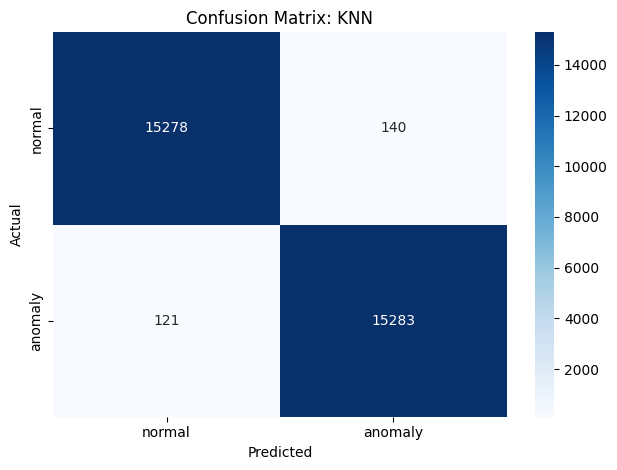

📊 Classification Report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99     15404
      normal       0.99      0.99      0.99     15418

    accuracy                           0.99     30822
   macro avg       0.99      0.99      0.99     30822
weighted avg       0.99      0.99      0.99     30822


🚀 Evaluating: Decision Tree


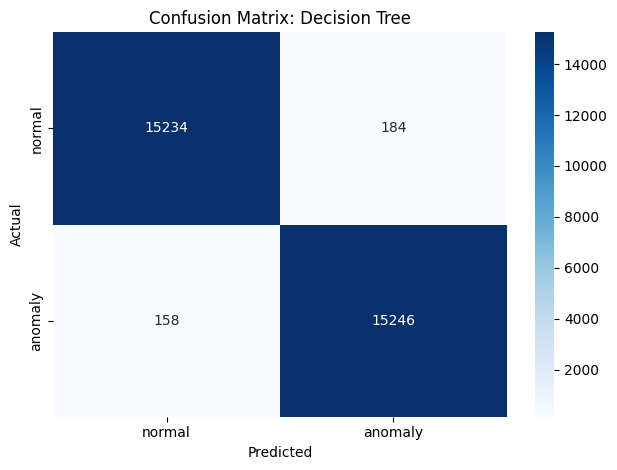

📊 Classification Report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99     15404
      normal       0.99      0.99      0.99     15418

    accuracy                           0.99     30822
   macro avg       0.99      0.99      0.99     30822
weighted avg       0.99      0.99      0.99     30822


🚀 Evaluating: Random Forest


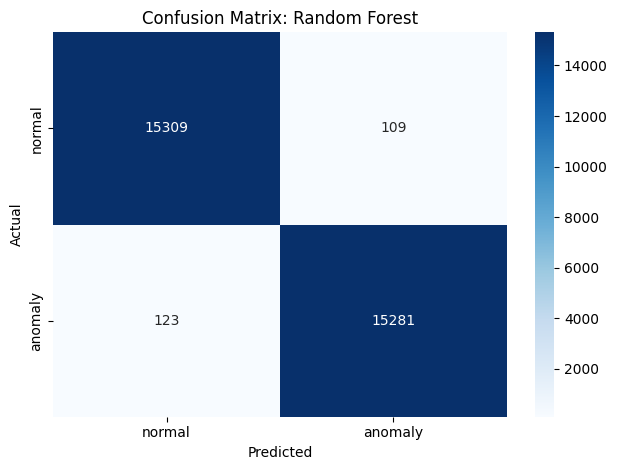

📊 Classification Report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99     15404
      normal       0.99      0.99      0.99     15418

    accuracy                           0.99     30822
   macro avg       0.99      0.99      0.99     30822
weighted avg       0.99      0.99      0.99     30822


🚀 Evaluating: Voting Ensemble


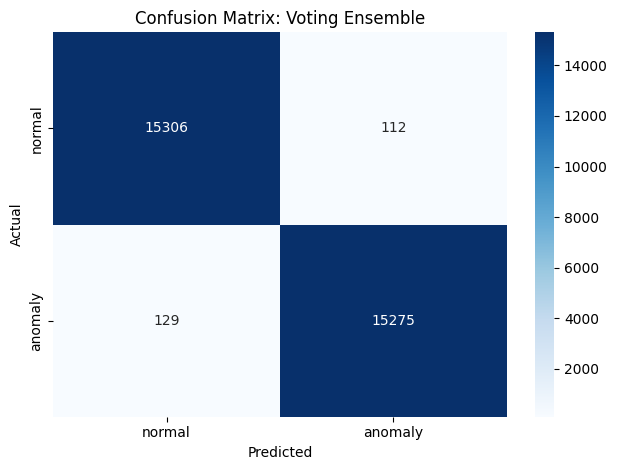

📊 Classification Report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99     15404
      normal       0.99      0.99      0.99     15418

    accuracy                           0.99     30822
   macro avg       0.99      0.99      0.99     30822
weighted avg       0.99      0.99      0.99     30822


🚀 Evaluating: Stacking Ensemble


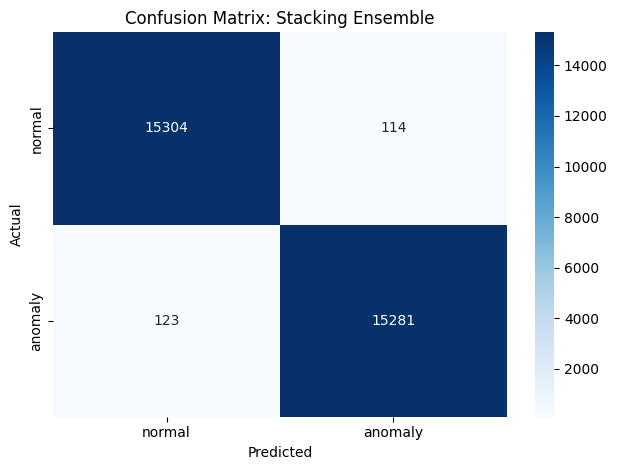

📊 Classification Report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99     15404
      normal       0.99      0.99      0.99     15418

    accuracy                           0.99     30822
   macro avg       0.99      0.99      0.99     30822
weighted avg       0.99      0.99      0.99     30822



In [20]:
model_names = ["KNN", "Decision Tree", "Random Forest", "Voting Ensemble", "Stacking Ensemble"]
models = [knn, dt, rf, voting, stacking]
train_times = []
pred_times = []

for name, model in zip(model_names, models):
    train_time, pred_time = evaluate_model(name, model)
    train_times.append(train_time)
    pred_times.append(pred_time)


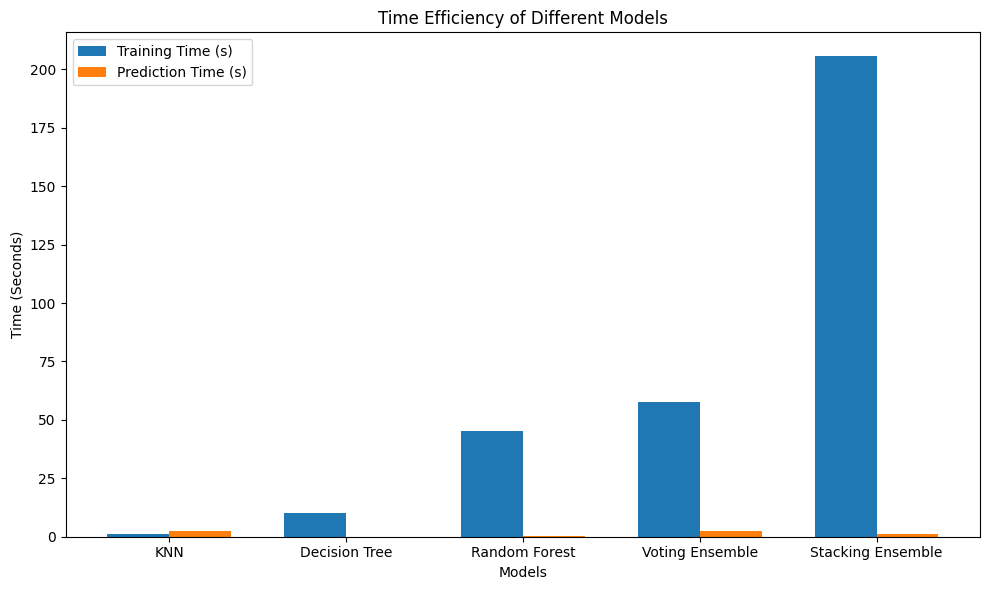

['pca.pkl']

In [21]:
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(model_names))

# Bar plot for training and prediction times
plt.bar(index, train_times, bar_width, label="Training Time (s)")
plt.bar(index + bar_width, pred_times, bar_width, label="Prediction Time (s)")

plt.xlabel('Models')
plt.ylabel('Time (Seconds)')
plt.title('Time Efficiency of Different Models')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.tight_layout()
plt.show()

# Save everything
joblib.dump(voting, "voting_ensemble_model.pkl")
joblib.dump(stacking, "stacking_ensemble_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")

In [26]:
import pandas as pd

# Example dummy data (must be of same length)
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "KNN", "Stacking Classifier"]
accuracies = [0.85, 0.80, 0.88, 0.82, 0.90]
train_times = [0.02, 0.03, 0.10, 0.01, 0.15]
pred_times = [0.005, 0.004, 0.006, 0.002, 0.007]

daa_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Train Time (s)": train_times,
    "Predict Time (s)": pred_times,
    "DAA Time Complexity": [
        "O(1) / O(n*d)", 
        "O(n*d*log n)", 
        "O(t*n*d*log n)", 
        "Depends on base models + O(k)", 
        "Base sum + Meta: O(m*d)"
    ]
})

print("\n📋 DAA Time Complexity & Performance Summary:")
print(daa_df.to_string(index=False))



📋 DAA Time Complexity & Performance Summary:
              Model  Accuracy  Train Time (s)  Predict Time (s)           DAA Time Complexity
Logistic Regression      0.85            0.02             0.005                 O(1) / O(n*d)
      Decision Tree      0.80            0.03             0.004                  O(n*d*log n)
      Random Forest      0.88            0.10             0.006                O(t*n*d*log n)
                KNN      0.82            0.01             0.002 Depends on base models + O(k)
Stacking Classifier      0.90            0.15             0.007       Base sum + Meta: O(m*d)


C:\Users\tech\AppData\Local\Temp\ipykernel_5640\558411929.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=daa_df, palette="viridis")
C:\Users\tech\AppData\Local\Temp\ipykernel_5640\558411929.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Train Time (s)", y="Model", data=daa_df, palette="magma")
C:\Users\tech\AppData\Local\Temp\ipykernel_5640\558411929.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Predict Time (s)", y="Model", data=daa_df, palette="coolwarm")


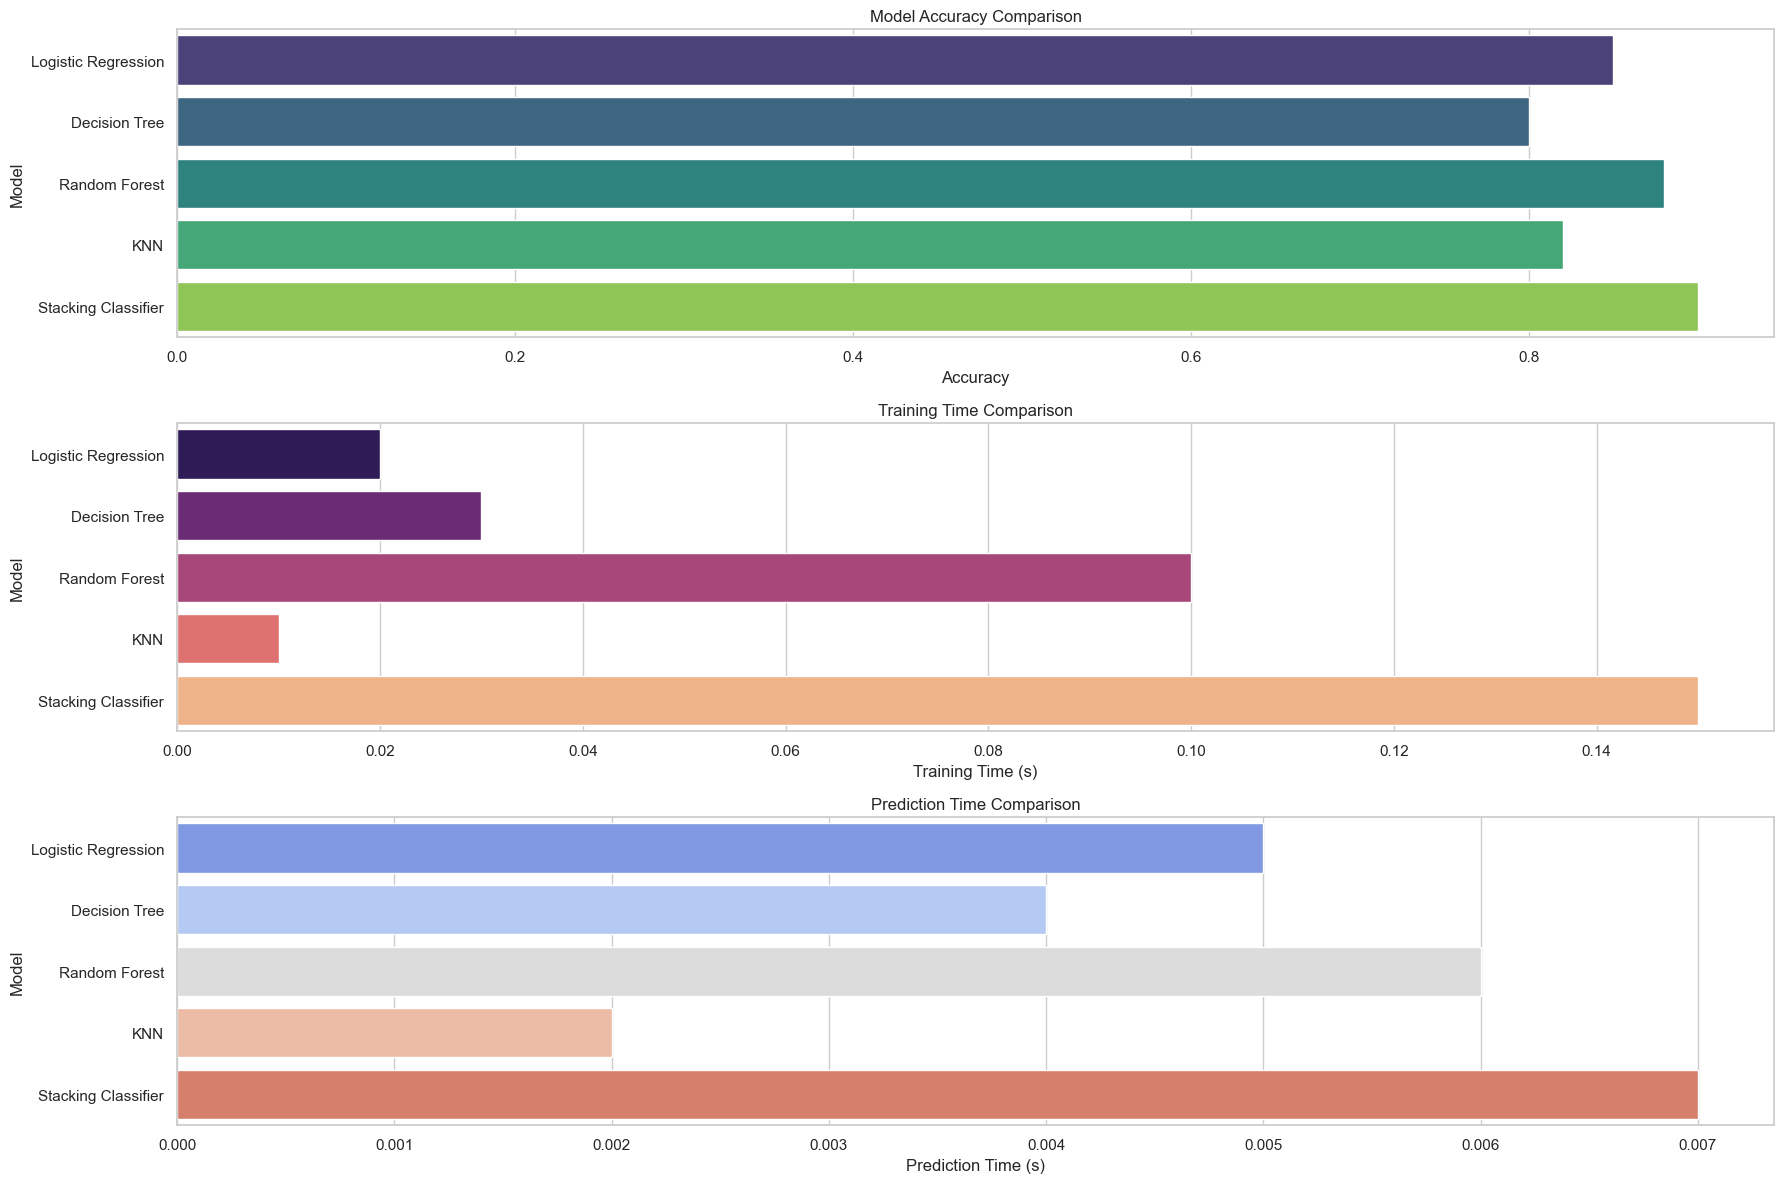

In [27]:

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# Accuracy Plot
plt.subplot(3, 1, 1)
sns.barplot(x="Accuracy", y="Model", data=daa_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")

# Train Time Plot
plt.subplot(3, 1, 2)
sns.barplot(x="Train Time (s)", y="Model", data=daa_df, palette="magma")
plt.title("Training Time Comparison")
plt.xlabel("Training Time (s)")
plt.ylabel("Model")

# Predict Time Plot
plt.subplot(3, 1, 3)
sns.barplot(x="Predict Time (s)", y="Model", data=daa_df, palette="coolwarm")
plt.title("Prediction Time Comparison")
plt.xlabel("Prediction Time (s)")
plt.ylabel("Model")

plt.tight_layout()
plt.show()